In [ ]:
# model_load_eval.ipynb

# This script can:
# - reload saved models in .joblib format that are already trained
# - load data 
# - make predictions
# - evaluate the model (classification reports, confusion matrix)


'Beispiel fuer Docstrings.\n\nDiese Klasse zeigt, wie Docstrings verwendet\nwerden. \n'

# load and eval model

## import libs

In [1]:
import numpy as np
import pandas as pd
import os

import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

# For hyperparamter testing
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

# For classification performance metrics
from sklearn.metrics import classification_report, confusion_matrix 

# for visualization:
import seaborn as sns
import matplotlib.pyplot as plt



# lib for accelreation sklearn on GPU (google colab)
#if machine == 'colab':
#    %load_ext cuml.accel
#    import sklearn

## definitions to set by user to run the script:

In [28]:
#####################################
# options for usable datasets:
#####################################

list_datasets = ['128_nomask', '128_mask', 'hog', '20_mask', '128_no_aug_mask', '128_no_aug_nomask']

# list_datasets[0] = '128_nomask'
# list_datasets[1] = '128_mask'
# list_datasets[2] = 'hog'
# list_datasets[3] = '20_mask'
# list_datasets[4] = '128_no_aug_mask'   (images 128 x 128, non augmented, with mask, in each class train: 1000 images, test: 269 images)
# list_datasets[5] = '128_no_aug_nomask' (images 128 x 128, non augmented, without mask, in each class train: 1000 images, test: 269 images)

# # choose one dataset by setting the number of element of list_datasets:
flag_dataset = list_datasets[3]

print(flag_dataset)



#####################################
# name of model to be loaded:
#####################################
model_name = "SVC_bay_20_mask_slice2000"
mode_file_name = model_name + ".joblib"


#####################################
# options to run on local computer:
#####################################

# set the following paramter = True when you run the script on local comupter. 
# This means a smaller dataset with less images will be used. 

flag_slicing = True    # True or False
num_subset = 500   # number of iamges of each class to use. parameter is only used when run_local = True


#####################################
# paths:
#####################################

# paths to load data:
base_path = r"..\\data\\"
base_path_in = os.path.join(base_path, "processed")   # path to read from the *.npy files

# paths to save models:
model_path = r"..\Models\local\ML"



20_mask


## load model

In [29]:

# load model instead of fitting it again
model_loaded = joblib.load(os.path.join(model_path, mode_file_name))

## functions

In [7]:
def create_cm(y_test, y_pred, flag_norm, model_path, model_name):
    
    if not (flag_norm is None):
        print("norma")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_norm.png")
        format_anot = '.2f'
    else:
        print("abs")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_abs.png")
        format_anot = 'd'

    cm = confusion_matrix(y_test, y_pred, normalize=flag_norm)

    list_labels_enc = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

    plt.figure(figsize=(7,7))
    sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=format_anot, xticklabels=list_labels_enc, yticklabels=list_labels_enc)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.savefig(cm_file, format='png')
    plt.show()

## loading images

### images resized to 128 * 128, normalized, without masks

In [ ]:
if flag_dataset == '128_nomask':

    train_npy_file = 'train_data_resized_without_masks_128_128.npz'
    test_npy_file  = 'test_data_resized_without_masks_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']


### images resized to 128 * 128, normalized, with masks (incl. Gaussian Blur, Clahe)

In [36]:
if flag_dataset == '128_mask':
    
    train_npy_file = 'train_data_resized_with_masks_128_128.npz'
    test_npy_file  = 'test_data_resized_with_masks_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### images resized to 20 * 20, normalized, with masks (incl. Gaussian Blur, Clahe)

In [15]:
if flag_dataset == '20_mask':
    
    train_npy_file = 'train_data_resized_with_masks_20_20.npz'
    test_npy_file  = 'test_data_resized_with_masks_20_20.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### feature extraction with HOG based on images original size 299 * 299, normalized, with masks (incl. Gaussian Blur, Clahe) and apllied masks

In [33]:
if flag_dataset == 'hog':

    base_path_in = os.path.join(base_path_in, "extracted")  # hog-files are in subfolder "extracted"

    train_npy_file = 'hog_features.npy'
    test_npy_file  = 'hog_features_test.npy'

    train_labels_file = 'labels_test.npy'
    test_labels_file = 'labels_train.npy'

    #train data
    X_train = np.load(os.path.join(base_path_in, train_npy_file))
    y_train = np.load(os.path.join(base_path_in, train_labels_file))

    # test data
    X_test = np.load(os.path.join(base_path_in, test_npy_file))
    y_test = np.load(os.path.join(base_path_in, test_labels_file))


### images resized to 128 * 128, normalized, with masks (incl. Gaussian Blur, Clahe) - non augmented (train: 1000 images, test: 269 images)

In [9]:
if flag_dataset == '128_no_aug_mask':
    
    train_npy_file = 'train_non_augmented_with_masks_resized_128_128.npz'
    test_npy_file  = 'test_non_augmented_with_masks_resized_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### images resized to 128 * 128, normalized, without masks (incl. Gaussian Blur, Clahe) - non augmented (train: 1000 images, test: 269 images)

In [10]:
if flag_dataset == '128_no_aug_nomask':
    
    train_npy_file = 'train_non_augmented_without_masks_resized_128_128.npz'
    test_npy_file  = 'test_non_augmented_without_masks_resized_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### print summary of loaded dataset

In [16]:
# print used datasets: 
print("------------------")
print("used datasets:")
print("train: ", train_npy_file)
print("test: ", test_npy_file)

------------------
used datasets:
train:  train_data_resized_with_masks_20_20.npz
test:  test_data_resized_with_masks_20_20.npz


In [17]:
# print length of datasets:
print("------------------")
print("Length of: ")
print("y_train: ", y_train.shape)
print("X_train: ", X_train.shape)

print("y_test: ", y_test.shape)
print("X_test: ",X_test.shape)


------------------
Length of: 
y_train:  (35059,)
X_train:  (35059, 400)
y_test:  (4233,)
X_test:  (4233, 400)


### optional slicing to use less images for running on local machine

In [18]:
if flag_slicing  == True:
    print(X_train.shape)
    print(y_train.shape)
    df_X_train = pd.DataFrame(X_train)
    df_y_train = pd.DataFrame(y_train)
    df_y_train.rename(columns={0:'label'}, inplace=True)
    df_temp = pd.concat([df_X_train, df_y_train], axis=1)

    print(df_y_train.columns)

    
    df_temp_0 = df_temp[(df_temp.iloc[:,-1]==0)].iloc[0:num_subset,]
    df_temp_1 = df_temp[(df_temp.iloc[:,-1]==1)].iloc[0:num_subset,]
    df_temp_2 = df_temp[(df_temp.iloc[:,-1]==2)].iloc[0:num_subset,]
    df_temp_3 = df_temp[(df_temp.iloc[:,-1]==3)].iloc[0:num_subset,]

    df_temp_subset = pd.concat([df_temp_0, df_temp_1, df_temp_2, df_temp_3], axis=0)

    #df_temp_subset.iloc[:,-1].value_counts()

    df_X_train_subset = df_temp_subset.drop(['label'], axis=1)
    #df_X_train_subset = df_temp_subset.drop(df_temp_subset.iloc[:,-1:], axis=1)
    df_y_train_subset = df_temp_subset.iloc[:,-1]

    X_train = df_X_train_subset.to_numpy()
    y_train = df_y_train_subset.to_numpy()

    print("y_train: ", (y_train.shape))
    print("X_train: ", (X_train.shape))

(35059, 400)
(35059,)
Index(['label'], dtype='object')
y_train:  (2000,)
X_train:  (2000, 400)


## modelling

### scaling

In [19]:
# sacling the data
scaler = StandardScaler()

# fit and transform train data 
X_train_scaled = scaler.fit_transform(X_train)

# fit test data
X_test_scaled = scaler.transform(X_test)

# scaling is not used because the standard-scaler scales along the columns and that means scaling over the same pixel in each image

# X_test_scaled = X_test
# X_train_scaled = X_train

## train loaded model

#### Evaluation

In [30]:
#print best hyperparamters:
print(model_loaded.best_params_)

# write best hyperparameters to file: 
with open(os.path.join(model_path, "results", "model_hyperparams.txt"), "a") as f:
  f.write(f'-------------------------------------------------------------------------------------------- \n')
  f.write(f'Tested model: {model_name} \n')
  for keys, value in model_loaded.best_params_.items():
      f.write(f'{keys}: {value} \n')

OrderedDict({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'})


In [31]:
#Predict the test features and create the confusion matrix
y_pred = model_loaded.predict(X_test_scaled)


In [32]:
# classification report
print(classification_report(y_test, y_pred))

# save report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(os.path.join(model_path, "results", model_name + "_cf_report.csv" ), index=True)



              precision    recall  f1-score   support

           0       0.42      0.23      0.29       723
           1       0.63      0.54      0.58      1203
           2       0.67      0.87      0.76      2038
           3       0.93      0.53      0.68       269

    accuracy                           0.65      4233
   macro avg       0.66      0.54      0.58      4233
weighted avg       0.63      0.65      0.62      4233



abs
None


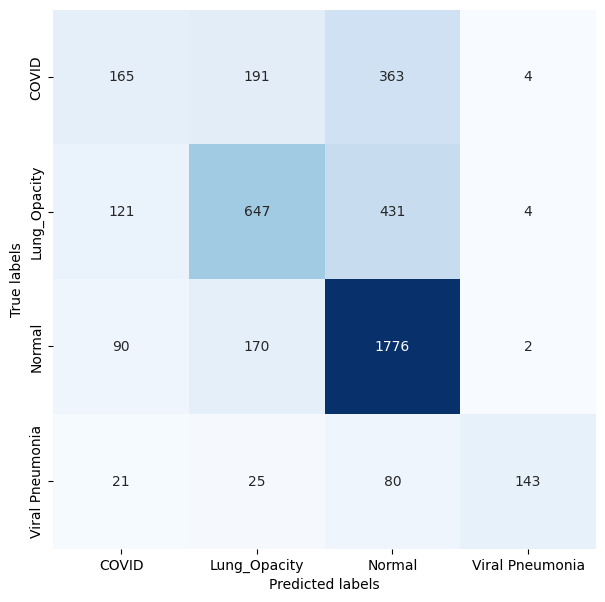

In [33]:
# show and saveonfusion matrix with absolute values: 
create_cm(y_test, y_pred, None , model_path, model_name)

norma
true


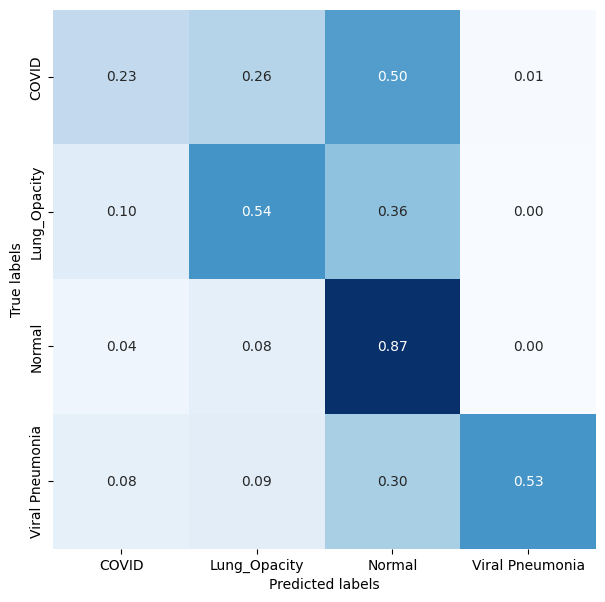

In [34]:
# show and saveonfusion matrix with normalized values: 
create_cm(y_test, y_pred, 'true' , model_path, model_name)